In [1]:
#titanic
# TODO: create family size variable, use cabin to get floor
# TODO: feature scaling or mean normalization?

import pandas as pd
import numpy as np
#visualization
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
#import sklearn
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
# data dictionary

#Variable	Definition	Key
#survival	Survival	0 = No, 1 = Yes
#pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
#sex	Sex	
#Age	Age in years	
#sibsp	# of siblings / spouses aboard the Titanic	
#parch	# of parents / children aboard the Titanic	
#ticket	Ticket number	
#fare	Passenger fare	
#cabin	Cabin number	
#embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [3]:
titanic_df = pd.read_csv('C:/Users/blahjays/Documents/MachineLearning/Kaggle/train.csv')
titanic_test= pd.read_csv('C:/Users/blahjays/Documents/MachineLearning/Kaggle/test.csv')

In [4]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# shape 891,12
print(titanic_df.shape)
# head
print(titanic_df.head(5))

(891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN    

In [6]:
# class distribution
print(titanic_df.groupby('Pclass').size())

Pclass
1    216
2    184
3    491
dtype: int64


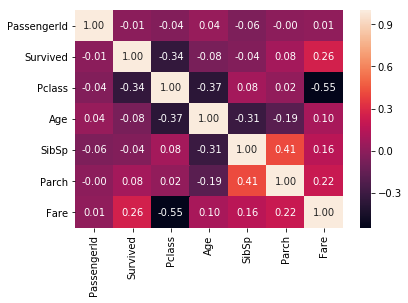

In [7]:
# Basic graphs to help understand data
# biggest correlations
# parch and sibsp are .41 positively correlated
#survived adn fare are .26 positively correlated
# sibsp and Age are .31 negatively correlated
# surived and pclass are -.34 negatively correlated
# pclass and age are .37 negatively correlated
# fare and pclass are .55 negatively correlated
        
sns.heatmap(titanic_df.corr(), annot=True, fmt=".2f")

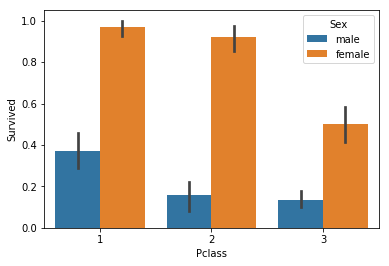

In [8]:
# compare Class and Surival by gender
# see upper class passengers more likely to survive and females much more liekly to surive in all classes
sns.barplot(x="Pclass", y="Survived", hue="Sex", data=titanic_df);

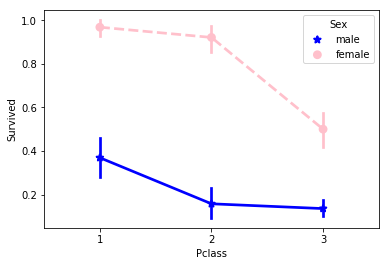

In [9]:
#plot pclass vs survival
# altnerative plot style
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=titanic_df,
palette={"male": "blue", "female": "pink"},
markers=["*", "o"], linestyles=["-", "--"]);

In [10]:
#Scatter plot -- SLOW!
#sns.pairplot(titanic_df, hue="Age")

*************************************************
Start Feature Engineering section
*************************************************

In [11]:
#look at family size by combining siblings/spouse and parent/child columns
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch']
titanic_test['FamilySize'] = titanic_test['SibSp'] + titanic_test['Parch']
titanic_df.sample(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
641,642,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C,0
383,384,1,1,"Holverson, Mrs. Alexander Oskar (Mary Aline To...",female,35.0,1,0,113789,52.0000,NaN,S,1
769,770,0,3,"Gronnestad, Mr. Daniel Danielsen",male,32.0,0,0,8471,8.3625,NaN,S,0
487,488,0,1,"Kent, Mr. Edward Austin",male,58.0,0,0,11771,29.7000,B37,C,0
286,287,1,3,"de Mulder, Mr. Theodore",male,30.0,0,0,345774,9.5000,NaN,S,0


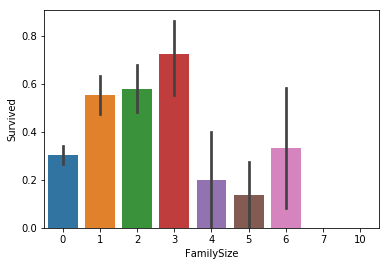

In [12]:
#plot impact of family size on survival
sns.barplot(x="FamilySize", y="Survived", data=titanic_df);

# seems best change of survival is with a small family 1-3


In [13]:
#extract Cabin info
# first lets examine some non null cabin data
titanic_df[titanic_df['Cabin'].notnull()]['Cabin'].count()
# have 204 rows with non null cabin data
# let's look at it
titanic_df[titanic_df['Cabin'].notnull()]['Cabin'].sample(10)

527        C95
370        E50
857        E17
390    B96 B98
292          D
632        B50
796        D17
712       C126
662        E58
193         F2
Name: Cabin, dtype: object

In [14]:
# most are in format C68, E46 etc
# see that we have some rows with multiple cabins: B51 B53 B55
# some rows only have Letter and no number

# let's try plotting Cabin vs survival rate
# plot NA vs Letter meaning
titanic_df['CabinLetter'] = titanic_df['Cabin'].str[0].fillna('ZZZ')
#titanic_df.sort_values(by=['CabinLetter'], axis=0)
titanic_df = titanic_df.sort_values(by='CabinLetter', ascending=True)
titanic_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinLetter
445,446,1,1,"Dodge, Master. Washington",male,4.0,0,2,33638,81.8583,A34,S,2,A
209,210,1,1,"Blank, Mr. Henry",male,40.0,0,0,112277,31.0000,A31,C,0,A
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C,0,A
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C,1,A
806,807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0000,A36,S,0,A
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S,0,A
185,186,0,1,"Rood, Mr. Hugh Roscoe",male,NaN,0,0,113767,50.0000,A32,S,0,A
867,868,0,1,"Roebling, Mr. Washington Augustus II",male,31.0,0,0,PC 17590,50.4958,A24,S,0,A
284,285,0,1,"Smith, Mr. Richard William",male,NaN,0,0,113056,26.0000,A19,S,0,A
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,C,1,A


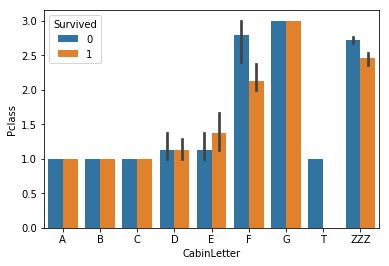

In [15]:
# plot relationship between Cabin floor, p place and survival
#TODO -- not a good plot
titanic_df.sort_values(by='CabinLetter', ascending=True)
#.sort_values(by='AgeBand', ascending=True)
sns.barplot(x="CabinLetter", y="Pclass", hue="Survived", data=titanic_df)
# Deck A is at top of ship

Decsion: don't believe cabin is a valuable field - highly correlated with class


In [16]:
# first pass at cleaning up data
#drop passengerid
#titanic_df = titanic_df.drop('PassengerId', axis=1).drop('Ticket',axis=1)
#titanic_df.head(5)

In [17]:
# convert sex to number, 0=male, 1=female
sex_mapping = {"male": 0, "female": 1}
titanic_df['Sex'] = titanic_df['Sex'].map(sex_mapping).astype(int)
titanic_test['Sex'] = titanic_test['Sex'].map(sex_mapping).astype(int)

In [18]:
# fill in missing ages
# first fill out titles
# add a computed title column
titanic_df['Title'] = titanic_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
titanic_test['Title'] = titanic_test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(titanic_df['Title'], titanic_df['Sex'])
pd.crosstab(titanic_test['Title'], titanic_test['Sex'])

# replace rare titles
#titanic_df[titanic_df['Title'] == 'Mlle']
titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss')
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs')
titanic_df['Title'] = titanic_df['Title'].replace('Countess', 'Mrs')
titanic_df['Title'] = titanic_df['Title'].replace('Lady', 'Mrs')
titanic_df['Title'] = titanic_df['Title'].replace('Jonkheer', 'Mr')
titanic_df['Title'] = titanic_df['Title'].replace('Don', 'Mr')
titanic_df['Title'] = titanic_df['Title'].replace('Capt', 'Mr')
titanic_df['Title'] = titanic_df['Title'].replace('Col', 'Mr')
titanic_df['Title'] = titanic_df['Title'].replace('Major', 'Mr')
titanic_df['Title'] = titanic_df['Title'].replace('Sir', 'Mr')
titanic_df['Title'] = titanic_df['Title'].replace('Rev', 'Mr')



titanic_test['Title'] = titanic_test['Title'].replace('Mlle', 'Miss')
titanic_test['Title'] = titanic_test['Title'].replace('Ms', 'Miss')
titanic_test['Title'] = titanic_test['Title'].replace('Mme', 'Mrs')
titanic_test['Title'] = titanic_test['Title'].replace('Countess', 'Mrs')
titanic_test['Title'] = titanic_test['Title'].replace('Lady', 'Mrs')
titanic_test['Title'] = titanic_test['Title'].replace('Jonkheer', 'Mr')
titanic_test['Title'] = titanic_test['Title'].replace('Don', 'Mr')
titanic_test['Title'] = titanic_test['Title'].replace('Capt', 'Mr')
titanic_test['Title'] = titanic_test['Title'].replace('Col', 'Mr')
titanic_test['Title'] = titanic_test['Title'].replace('Major', 'Mr')
titanic_test['Title'] = titanic_test['Title'].replace('Sir', 'Mr')
titanic_test['Title'] = titanic_test['Title'].replace('Rev', 'Mr')
#now get average age for each title
#pd.crosstab(titanic_df['Title'], titanic_df['AgeBand'])


In [19]:
#now get average age for each title
title_avg_age_df = titanic_df[['Age' , 'Title']].groupby(['Title']).mean()
title_avg_age_df

,Age
Title,
Dr,42.000000
Master,4.574167
Miss,21.845638
Mr,32.891990
Mrs,35.873874


In [20]:
# convert title values to number
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5}

titanic_df['Title'] = titanic_df['Title'].map(title_mapping)
titanic_df['Title'] = titanic_df['Title'].fillna(0)
titanic_test['Title'] = titanic_test['Title'].map(title_mapping)
titanic_test['Title'] = titanic_test['Title'].fillna(0)

titanic_df.head()




,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinLetter,Title
445,446,1,1,"Dodge, Master. Washington",0,4.0,0,2,33638,81.8583,A34,S,2,A,4
209,210,1,1,"Blank, Mr. Henry",0,40.0,0,0,112277,31.0000,A31,C,0,A,1
96,97,0,1,"Goldschmidt, Mr. George B",0,71.0,0,0,PC 17754,34.6542,A5,C,0,A,1
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",0,49.0,1,0,PC 17485,56.9292,A20,C,1,A,1
806,807,0,1,"Andrews, Mr. Thomas Jr",0,39.0,0,0,112050,0.0000,A36,S,0,A,1


In [21]:
#now get average age for each title
title_avg_age_df = titanic_df[['Age' , 'Title']].groupby(['Title']).mean()
title_avg_age_df

,Age
Title,
1,32.891990
2,21.845638
3,35.873874
4,4.574167
5,42.000000


In [22]:
age_mapping = title_avg_age_df.to_dict()
age_mapping

{'Age': {1: 32.891990291262132,
  2: 21.845637583892618,
  3: 35.873873873873876,
  4: 4.5741666666666667,
  5: 42.0}}

In [23]:
title_mapping

{'Dr': 5, 'Master': 4, 'Miss': 2, 'Mr': 1, 'Mrs': 3}

In [24]:
age_mapping['Age']

{1: 32.891990291262132,
 2: 21.845637583892618,
 3: 35.873873873873876,
 4: 4.5741666666666667,
 5: 42.0}

In [25]:
# get Nan age rows
#map the average age based on title to the missing age values (nan)
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Title'].map((age_mapping['Age'])))
titanic_test['Age'] = titanic_test['Age'].fillna(titanic_test['Title'].map((age_mapping['Age'])))
titanic_df.head(3)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinLetter,Title
445,446,1,1,"Dodge, Master. Washington",0,4.0,0,2,33638,81.8583,A34,S,2,A,4
209,210,1,1,"Blank, Mr. Henry",0,40.0,0,0,112277,31.0000,A31,C,0,A,1
96,97,0,1,"Goldschmidt, Mr. George B",0,71.0,0,0,PC 17754,34.6542,A5,C,0,A,1


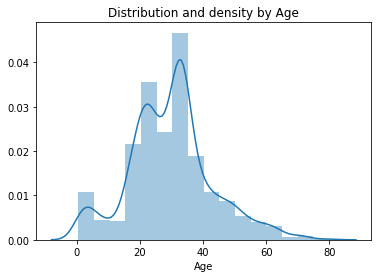

In [26]:
sns.distplot(titanic_df["Age"], bins=16)
plt.title("Distribution and density by Age")
plt.xlabel("Age")

In [27]:
# create Age bands
titanic_df['AgeBand'] = pd.cut(titanic_df['Age'], 5, labels=[1,2,3,4,5])
titanic_test['AgeBand'] = pd.cut(titanic_test['Age'], 5, labels=[1,2,3,4,5])
# create table of survival rates per age band
agedist_df = titanic_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

agedist_df

,AgeBand,Survived
0,1,0.548077
1,2,0.392670
2,3,0.320000
3,4,0.434783
4,5,0.090909


In [28]:
titanic_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinLetter,Title,AgeBand
445,446,1,1,"Dodge, Master. Washington",0,4.00000,0,2,33638,81.8583,A34,S,2,A,4,1
209,210,1,1,"Blank, Mr. Henry",0,40.00000,0,0,112277,31.0000,A31,C,0,A,1,3
96,97,0,1,"Goldschmidt, Mr. George B",0,71.00000,0,0,PC 17754,34.6542,A5,C,0,A,1,5
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",0,49.00000,1,0,PC 17485,56.9292,A20,C,1,A,1,4
806,807,0,1,"Andrews, Mr. Thomas Jr",0,39.00000,0,0,112050,0.0000,A36,S,0,A,1,3
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",0,80.00000,0,0,27042,30.0000,A23,S,0,A,1,5
185,186,0,1,"Rood, Mr. Hugh Roscoe",0,32.89199,0,0,113767,50.0000,A32,S,0,A,1,3
867,868,0,1,"Roebling, Mr. Washington Augustus II",0,31.00000,0,0,PC 17590,50.4958,A24,S,0,A,1,2
284,285,0,1,"Smith, Mr. Richard William",0,32.89199,0,0,113056,26.0000,A19,S,0,A,1,3
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",1,48.00000,1,0,11755,39.6000,A16,C,1,A,3,3


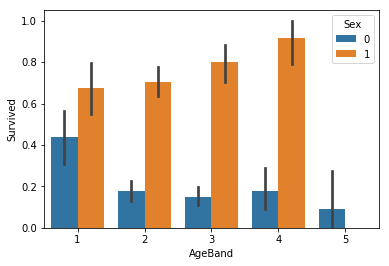

In [29]:
sns.barplot(x="AgeBand", y="Survived", hue="Sex", data=titanic_df);

#young males have best chance of survival among men
# older females have best chance of survival


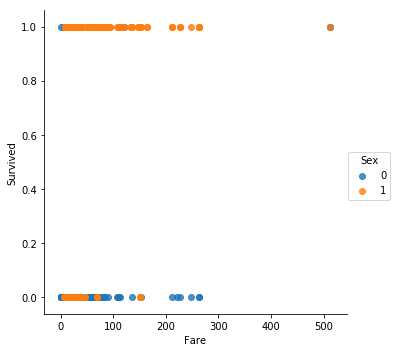

In [30]:

# Recommended way
sns.lmplot(x='Fare', y='Survived', hue='Sex',data=titanic_df, fit_reg=False)

In [31]:
#plot fare vs survival

#sns.pointplot(x="Fare", y="Survived", hue="Sex", data=titanic_df,
#palette={0: "blue", 1: "pink"},
#markers=["*", "o"], linestyles=["-", "--"]);

In [32]:
titanic_df.Fare.describe() 

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [33]:
#get average fare for each class
fare_avg_class_df = titanic_df[['Pclass' , 'Fare']].groupby(['Pclass']).mean()
fare_avg_class_df

,Fare
Pclass,
1,84.154687
2,20.662183
3,13.675550


In [34]:
#map the average fare based on pclass to the missing age values (nan)
fare_mapping = fare_avg_class_df.to_dict()
titanic_df['Fare'] = titanic_df['Fare'].fillna(titanic_df['Pclass'].map((fare_mapping['Fare'])))
titanic_test['Fare'] = titanic_test['Fare'].fillna(titanic_test['Pclass'].map((fare_mapping['Fare'])))
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,CabinLetter,Title,AgeBand
445,446,1,1,"Dodge, Master. Washington",0,4.0,0,2,33638,81.8583,A34,S,2,A,4,1
209,210,1,1,"Blank, Mr. Henry",0,40.0,0,0,112277,31.0000,A31,C,0,A,1,3
96,97,0,1,"Goldschmidt, Mr. George B",0,71.0,0,0,PC 17754,34.6542,A5,C,0,A,1,5


In [35]:
# create bands out of fare to simplify
# set bins to quartile
bins = (-1, 0, 8, 15, 31, 1000)

titanic_df['FareBand'] = pd.cut(titanic_df['Fare'], bins,labels=[1,2,3,4,5])
titanic_test['FareBand'] = pd.cut(titanic_test['Fare'], bins,labels=[1,2,3,4,5])
#titanic_df.head(50)
# create table of survival rates per age band
faredist_df = titanic_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)
faredist_df

,FareBand,Survived
0,1,0.066667
1,2,0.225664
2,3,0.285714
3,4,0.469194
4,5,0.581081


In [36]:
#titanic_train[
#titanic_train['FareBand' == 4]
# class distribution
print(titanic_df.groupby('FareBand').size())
#sns.distplot(titanic_train.FareBand)


FareBand
1     15
2    226
3    217
4    211
5    222
dtype: int64


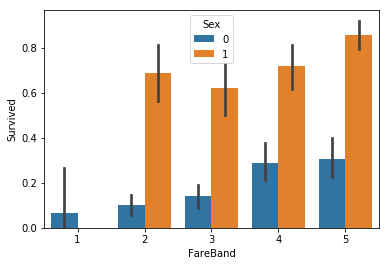

In [37]:
sns.barplot(x="FareBand", y="Survived", hue="Sex", data=titanic_df);

# first class have best chance of survival

In [38]:
#pd.scatter_matrix(titanic_train, alpha = 0.3, figsize = (14,8), diagonal = 'kde');


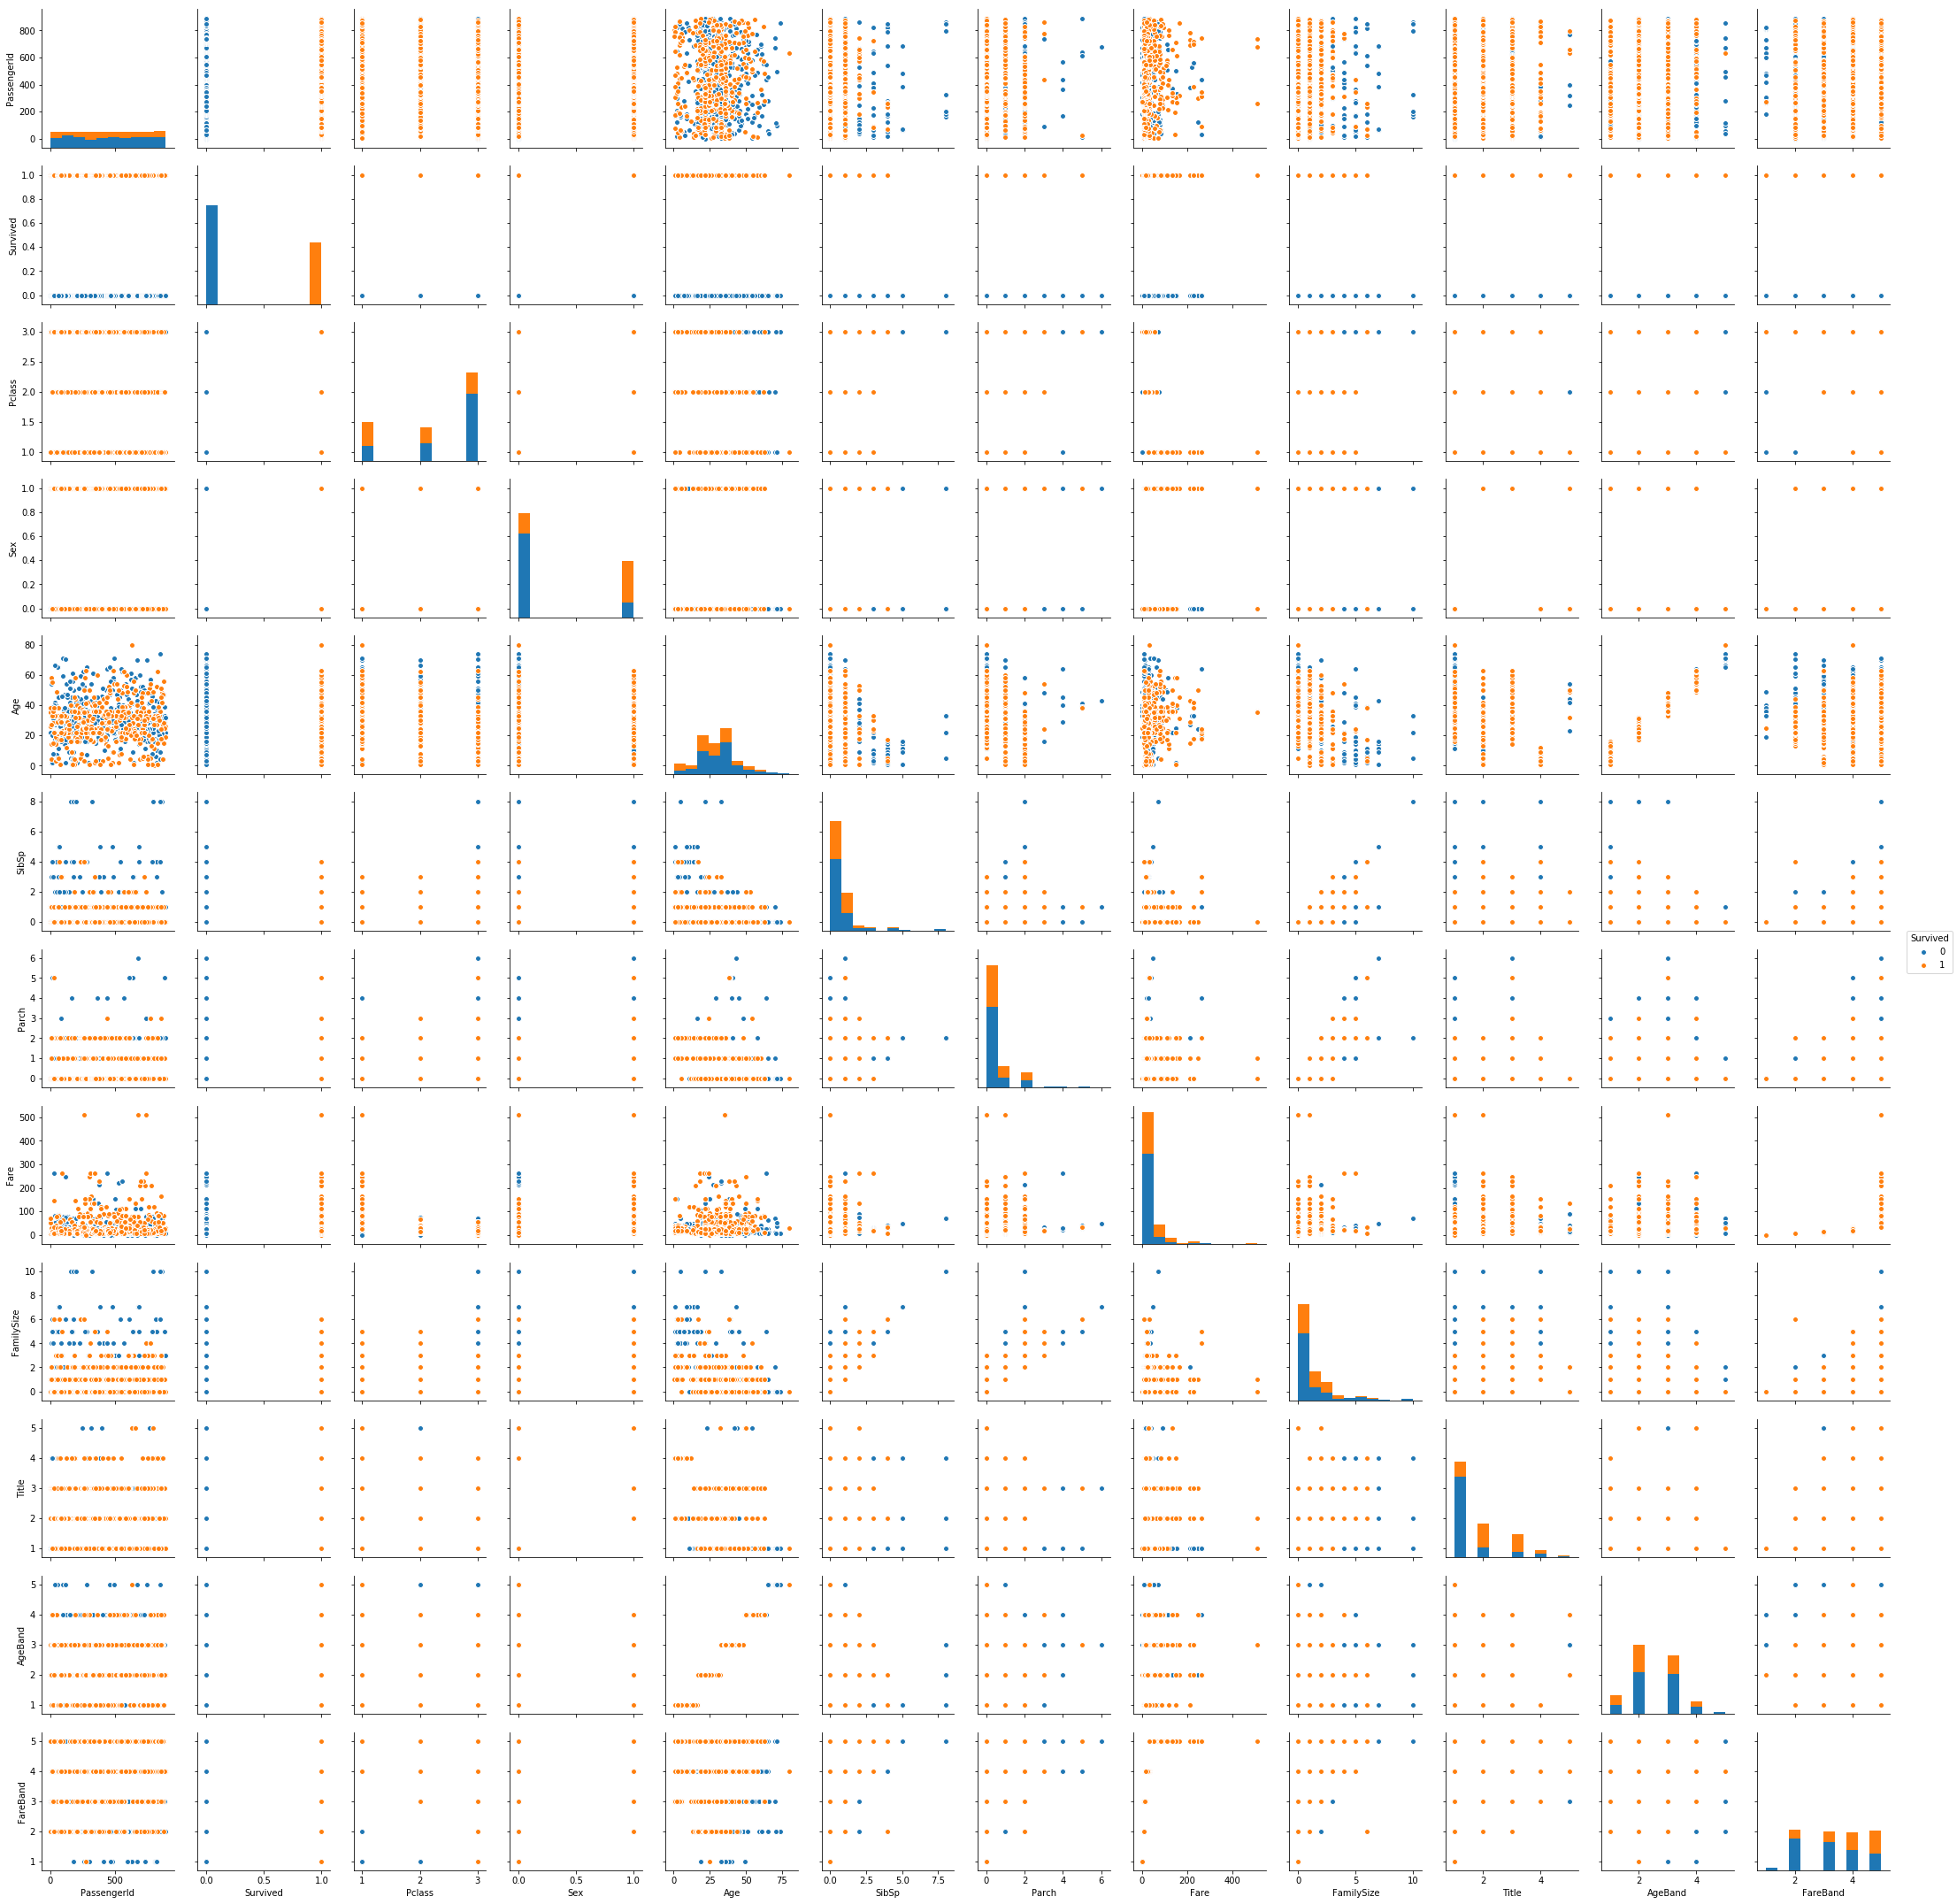

In [39]:
sns.pairplot(titanic_df, hue="Survived")

In [40]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.827062,0.523008,0.381594,32.204208,0.904602,1.661055
std,257.353842,0.486592,0.836071,0.477990,13.290197,1.102743,0.806057,49.693429,1.613459,0.935948
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,0.000000,21.845638,0.000000,0.000000,7.910400,0.000000,1.000000
50%,446.000000,0.000000,3.000000,0.000000,30.000000,0.000000,0.000000,14.454200,0.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,35.873874,1.000000,0.000000,31.000000,1.000000,2.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,10.000000,5.000000


In [41]:
titanic_test.sample(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title,AgeBand,FareBand
328,1220,2,"Clarke, Mr. Charles Valentine",0,29.0,1,0,2003,26.0000,NaN,S,1,1.0,2,4
231,1123,1,"Willard, Miss. Constance",1,21.0,0,0,113795,26.5500,NaN,S,0,2.0,2,4
77,969,1,"Cornell, Mrs. Robert Clifford (Malvina Helen L...",1,55.0,2,0,11770,25.7000,C101,S,2,3.0,4,4
115,1007,3,"Chronopoulos, Mr. Demetrios",0,18.0,1,0,2680,14.4542,NaN,C,1,1.0,2,3
118,1010,1,"Beattie, Mr. Thomson",0,36.0,0,0,13050,75.2417,C6,C,0,1.0,3,5
373,1265,2,"Harbeck, Mr. William H",0,44.0,0,0,248746,13.0000,NaN,S,0,1.0,3,3
287,1179,1,"Snyder, Mr. John Pillsbury",0,24.0,1,0,21228,82.2667,B45,S,1,1.0,2,5
31,923,2,"Jefferys, Mr. Clifford Thomas",0,24.0,2,0,C.A. 31029,31.5000,NaN,S,2,1.0,2,5
11,903,1,"Jones, Mr. Charles Cresson",0,46.0,0,0,694,26.0000,NaN,S,0,1.0,4,4
34,926,1,"Mock, Mr. Philipp Edmund",0,30.0,1,0,13236,57.7500,C78,C,1,1.0,2,5


In [42]:
# Now drop the columns we don't need to create our training nad test sets

#drop passengerid #drop Fare and Title
#drop age cabin embarked and name from data set used for training
titanic_train = titanic_df
titanic_train = titanic_df.drop('Ticket',axis=1).drop('Name', axis=1).drop('Age',axis=1).drop('Cabin',axis=1).drop('Embarked', axis=1)
titanic_train = titanic_train.drop('Fare', axis=1).drop('Title', axis=1).drop('SibSp',axis=1).drop('Parch',axis=1).drop('CabinLetter',axis=1)
#drop('PassengerId', axis=1).
titanic_test = titanic_test.drop('Ticket',axis=1).drop('Name', axis=1).drop('Age',axis=1).drop('Cabin',axis=1).drop('Embarked', axis=1)
titanic_test = titanic_test.drop('Fare', axis=1).drop('Title', axis=1).drop('SibSp',axis=1).drop('Parch',axis=1)

titanic_train.head(10)

,PassengerId,Survived,Pclass,Sex,FamilySize,AgeBand,FareBand
445,446,1,1,0,2,1,5
209,210,1,1,0,0,3,4
96,97,0,1,0,0,5,5
599,600,1,1,0,1,4,5
806,807,0,1,0,0,3,1
630,631,1,1,0,0,5,4
185,186,0,1,0,0,3,5
867,868,0,1,0,0,2,5
284,285,0,1,0,0,3,4
556,557,1,1,1,1,3,5


In [43]:
#now ready to run tests

In [44]:
# create Y array and X array
y_vals = titanic_train['Survived']
titanic_train = titanic_train.drop('Survived', axis=1)
y_vals.head(10)



445    1
209    1
96     0
599    1
806    0
630    1
185    0
867    0
284    0
556    1
Name: Survived, dtype: int64

In [45]:
# we also need to preserve the passenger id so can submit the preditions
PassengerId_train = titanic_train['PassengerId']
titanic_train.drop('PassengerId', axis=1, inplace=True)

PassengerId_test =  titanic_test['PassengerId']
titanic_test.drop('PassengerId', axis=1, inplace=True)

In [46]:
#PassengerId_test =  titanic_test['PassengerId'].copy()
#titanic_test.describe

In [47]:
# repeat for test
#titanic_test.head(10)
#ytest_vals = titanic_test['Survived']
#titanic_test = titanic_test.drop('Survived', axis=1)

In [48]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, titanic_train, y_vals, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.799076 (0.042281)
LDA: 0.794594 (0.041531)
KNN: 0.827166 (0.047433)
CART: 0.808190 (0.072803)
NB: 0.778976 (0.046400)
SVM: 0.826092 (0.040284)


In [49]:
# check for any nulls
nans = lambda titanic_test: titanic_test[titanic_test.isnull().any(axis=1)]
nans(titanic_test)

,Pclass,Sex,FamilySize,AgeBand,FareBand


In [50]:
(testlen, b)=titanic_test.shape
testlen

418

In [51]:
# Support Vector Machines

svc = SVC()

svc.fit(titanic_train, y_vals)
#c sets the regularization parameters.   small value for C means the margin is calculated using many or all of
#the observations around the separating line (more regularization); a large value for C means the margin is calculated on 
#observations close to the separating line (less regularization).
SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

svc.score(titanic_train, y_vals)



0.83389450056116721

In [52]:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
#print(svc.predict([[1,1,1,1,1]]))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
#a = svc.predict(titanic_test[100:105] )


In [54]:
#create array from DF for predictions
#titanic_test.values

In [55]:
y_predict = svc.predict(titanic_test.values) #[1:testlen])
#y_predict

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [56]:
#confusion_matrix(y_predict, y_vals)



(418, 5)

(418,)

415    1307
416    1308
417    1309
Name: PassengerId, dtype: int64

In [59]:
# add survival predictions back into Dataset
titanic_test['PassengerID'] = PassengerId_test
titanic_test['Survived'] = pd.Series(y_predict)

In [60]:
titanic_test.shape

(418, 7)

In [64]:
#titanic_test.head(10)

In [62]:
titanic_test.to_csv("C:/Users/blahjays/Documents/MachineLearning/Kaggle/svcoutput.csv", index=False)

NameError: name 'caller' is not defined

In [ ]:
# Logistic Regression

logreg = LogisticRegression()

logreg.fit(titanic_train, y_vals)

#Y_pred = logreg.predict(X_test)

logreg.score(titanic_train, y_vals)

In [ ]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(titanic_train, y_vals)

#Y_pred = random_forest.predict(X_test)

random_forest.score(titanic_train, y_vals)

In [ ]:
# now make predictions based on test set
# but we don't have survival info
# create Y array and X array
#y_vals_test = titanic_test['Survived']
#titanic_test = titanic_test.drop('Survived', axis=1)
#y_vals_test.head(10)

In [ ]:


# Train the model
#logreg = LogisticRegression()
#logreg.fit(titanic_train, y_vals)

# Get accuracy percentitanic_testtage
#logreg.score(titanic_test, y_vals_test)
